[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vicvenet/GenAI_for_Innovative_Communications/blob/main/2025_S1/Week_8/Social_media_monitoring.ipynb)

# Social Media Emotion Analysis in Chinese with RoBERTa-WWM
This script implements fine-tuning of Chinese RoBERTa-WWM model using LoRA (Low-Rank Adaptation)
for the CLUEemotion dataset classification task so that it can be used for emotion
analysis of Chinese texts.
The reason for using LoRA is that it allows to fine-tune the model with a smaller
number of trainable parameters, which is more efficient and easier to manage.

Install the required libraries

In [1]:
!pip install torch>=2.0.0 transformers>=4.30.0 datasets>=2.12.0 peft>=0.4.0
!pip install tqdm>=4.65.0 scikit-learn>=1.2.2 pandas>=2.0.3 seaborn>=0.12.2
!pip install matplotlib>=3.5.0 numpy>=1.22.0 requests>=2.28.0

Import required libraries

In [2]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    AdamW,
    AutoModelForSeq2SeqLM
)
from peft import get_peft_model, LoraConfig, TaskType
from tqdm.auto import tqdm
import torch
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader
import os
from pathlib import Path
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt  # Still needed as backend for seaborn
import numpy as np
import requests
import sys

## Directory Setup
Create necessary directories for saving model, dataset, and tokenized data

In [3]:
SAVE_DIR = Path("saved_data")
MODEL_DIR = SAVE_DIR / "model"
DATASET_DIR = SAVE_DIR / "dataset"
TOKENIZED_DIR = SAVE_DIR / "tokenized_dataset"
CHARTS_DIR = SAVE_DIR / "charts"
PROCESSED_INPUTS_DIR = SAVE_DIR / "processed_inputs"
LORA_DIR = MODEL_DIR / "trained_LoRA"  # New directory for LoRA adapters

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(TOKENIZED_DIR, exist_ok=True)
os.makedirs(CHARTS_DIR, exist_ok=True)
os.makedirs(PROCESSED_INPUTS_DIR, exist_ok=True)
os.makedirs(LORA_DIR, exist_ok=True)  # Create LoRA directory

## GPU Memory Cleanup
Clear any existing models from GPU memory to start with a clean state

In [4]:
# Function to clear GPU memory
def clear_gpu_memory():
    """
    Clear GPU memory to prevent memory issues when loading models
    """
    if torch.cuda.is_available():
        print("GPU detected. Clearing GPU memory...")

        # First collect Python garbage to release references
        import gc
        gc.collect()

        # Empty CUDA cache
        torch.cuda.empty_cache()

        # Reset peak memory stats
        torch.cuda.reset_peak_memory_stats()

        # Additional memory checks and cleanup
        if hasattr(torch.cuda, 'memory_stats'):
            before = torch.cuda.memory_allocated() / 1024 / 1024
            print(f"GPU memory in use before cleanup: {before:.2f} MB")

        # Force synchronize CUDA to complete pending operations
        torch.cuda.synchronize()

        # Empty cache again after synchronization
        torch.cuda.empty_cache()

        # Report memory after cleanup
        if hasattr(torch.cuda, 'memory_stats'):
            after = torch.cuda.memory_allocated() / 1024 / 1024
            print(f"GPU memory in use after cleanup: {after:.2f} MB")

        print("GPU memory cleared")
    else:
        print("No GPU detected, skipping memory cleanup")

# Clear GPU memory at the start
clear_gpu_memory()

GPU detected. Clearing GPU memory...
GPU memory in use before cleanup: 0.00 MB
GPU memory in use after cleanup: 0.00 MB
GPU memory cleared


## Dataset Loading
Load the CLUEemotion dataset with the Hugging Face dataset library, using cached version if available

Define the URLs to download the dataset files

In [5]:
dataset_urls = {
    'train': 'https://raw.githubusercontent.com/cque7/CLUEmotionAnalysis2020/master/CLUEdataset/emotion/train.txt',
    'valid': 'https://raw.githubusercontent.com/cque7/CLUEmotionAnalysis2020/master/CLUEdataset/emotion/valid.txt',
    'test': 'https://raw.githubusercontent.com/cque7/CLUEmotionAnalysis2020/master/CLUEdataset/emotion/test.txt'
}

# Function to download dataset files
def download_dataset_file(url, file_path):
    """Download a file if it doesn't exist locally"""
    if not os.path.exists(file_path):
        print(f"Downloading {url} to {file_path}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded successfully.")
        else:
            raise Exception(f"Failed to download {url}. Status code: {response.status_code}")
    else:
        print(f"File {file_path} already exists. Skipping download.")

# Create dataset directory for CLUE emotion
clue_emotion_dir = DATASET_DIR / "clue_emotion"
os.makedirs(clue_emotion_dir, exist_ok=True)

# Download dataset files
local_dataset_files = {}
for split, url in dataset_urls.items():
    file_path = clue_emotion_dir / f"{split}.txt"
    local_dataset_files[split] = file_path
    download_dataset_file(url, file_path)

# Load the dataset
dataset_path = DATASET_DIR / "clue_emotion_processed"
if os.path.exists(dataset_path):
    print("Loading cached dataset...")
    dataset = load_dataset("json",
                         data_files={
                             'train': str(local_dataset_files['train']),
                             'validation': str(local_dataset_files['valid']),
                             'test': str(local_dataset_files['test'])
                         },
                         cache_dir=str(dataset_path))
else:
    print("Loading dataset from files...")
    dataset = load_dataset("json",
                         data_files={
                             'train': str(local_dataset_files['train']),
                             'validation': str(local_dataset_files['valid']),
                             'test': str(local_dataset_files['test'])
                         })
    dataset.save_to_disk(str(dataset_path))

# Examine dataset structure
print("\nDataset structure:")
for split in dataset:
    print(f"{split}: {dataset[split].features}")
    print(f"Number of examples: {len(dataset[split])}")

# Check for list-type labels in the dataset
def check_label_types(dataset_split):
    list_labels_count = 0
    string_labels_count = 0
    other_labels_count = 0
    unique_labels = set()

    for example in dataset_split:
        label = example['label']
        if isinstance(label, list):
            list_labels_count += 1
        elif isinstance(label, str):
            string_labels_count += 1
            unique_labels.add(label)
        else:
            other_labels_count += 1

    return {
        'list_labels': list_labels_count,
        'string_labels': string_labels_count,
        'other_labels': other_labels_count,
        'unique_labels': unique_labels
    }

print("\nLabel type analysis:")
for split in dataset:
    print(f"\n{split.upper()} split:")
    label_stats = check_label_types(dataset[split])
    print(f"List labels count: {label_stats['list_labels']}")
    print(f"String labels count: {label_stats['string_labels']}")
    print(f"Other labels count: {label_stats['other_labels']}")
    print(f"Unique string labels: {sorted(label_stats['unique_labels'])}")

# Define the emotion categories from CLUEmotionAnalysis2020 dataset
# Based on the README: like, happiness, sadness, anger, disgust, fear and surprise
CATEGORIES = [
    "like",
    "happiness",
    "sadness",
    "anger",
    "disgust",
    "fear",
    "surprise"
]
num_labels = len(CATEGORIES)
print(f"Number of emotion labels: {num_labels}")

# Create label to id mapping
label_to_id = {label: i for i, label in enumerate(CATEGORIES)}

# Print first few examples of the training set to verify
print("\nSample data from the emotion dataset:")
for i in range(3):
    print(f"Example {i}:")
    print(f"Content: {dataset['train'][i]['content']}")
    print(f"Label: {dataset['train'][i]['label']}")
    print(f"Label ID: {label_to_id.get(dataset['train'][i]['label'], -1)}")
    print()

Downloaded successfully.
Downloaded successfully.
Downloaded successfully.
Loading dataset from files...


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/31728 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3966 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3967 [00:00<?, ? examples/s]


Dataset structure:
train: {'id': Value(dtype='int64', id=None), 'content': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}
Number of examples: 31728
validation: {'id': Value(dtype='int64', id=None), 'content': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}
Number of examples: 3966
test: {'id': Value(dtype='int64', id=None), 'content': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}
Number of examples: 3967

Label type analysis:

TRAIN split:
List labels count: 0
String labels count: 31728
Other labels count: 0
Unique string labels: ['anger', 'disgust', 'fear', 'happiness', 'like', 'sadness', 'surprise']

VALIDATION split:
List labels count: 0
String labels count: 3966
Other labels count: 0
Unique string labels: ['anger', 'disgust', 'fear', 'happiness', 'like', 'sadness', 'surprise']

TEST split:
List labels count: 0
String labels count: 3967
Other labels count: 0
Unique string labels: ['anger', 'disgust', 'fea

## Model Initialization
Initialize the Chinese RoBERTa model and tokenizer using the Hugging Face library transformers

Initialize the tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Initialize or load the model

In [7]:
# Clear GPU memory before loading model
clear_gpu_memory()
max_length = 360
model_path = LORA_DIR / "chinese_roberta_lora_clue_emotions"
if os.path.exists(model_path):
    print("Loading saved LoRA adapter...")
    try:
        # Attempt to load with memory-efficient settings
        model = AutoModelForSequenceClassification.from_pretrained(
            str(model_path),
            num_labels=num_labels,  # Ensure consistent number of labels
            torch_dtype=torch.float16,  # Use half precision
            low_cpu_mem_usage=True
        )
    except Exception as e:
        print(f"Warning: Error loading with optimized settings: {e}")
        # Fallback to standard loading
        model = AutoModelForSequenceClassification.from_pretrained(
            str(model_path),
            num_labels=num_labels
        )
else:
    print("Initializing new model...")
    try:
        # Attempt to initialize with memory-efficient settings
        model = AutoModelForSequenceClassification.from_pretrained(
            "hfl/chinese-roberta-wwm-ext",
            num_labels=num_labels,
            torch_dtype=torch.float16,  # Use half precision
            low_cpu_mem_usage=True
        )
    except Exception as e:
        print(f"Warning: Error initializing with optimized settings: {e}")
        # Fallback to standard initialization
        model = AutoModelForSequenceClassification.from_pretrained(
            "hfl/chinese-roberta-wwm-ext",
            num_labels=num_labels
        )

# Print memory usage after model loading
if torch.cuda.is_available() and hasattr(torch.cuda, 'memory_stats'):
    mem_allocated = torch.cuda.memory_allocated() / 1024 / 1024
    print(f"GPU memory allocated after model loading: {mem_allocated:.2f} MB")

GPU detected. Clearing GPU memory...
GPU memory in use before cleanup: 0.00 MB
GPU memory in use after cleanup: 0.00 MB
GPU memory cleared
Initializing new model...


pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU memory allocated after model loading: 0.00 MB


## LoRA Configuration
Configure Low-Rank Adaptation parameters

Configure LoRa with target modules

In [8]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    # Target modules for Chinese RoBERTa model
    target_modules=["query", "key", "value", "output.dense"]
)

Apply LoRa to the model

In [9]:
model = get_peft_model(model, lora_config)

## Data Processing
Define tokenization function and prepare the dataset

In [10]:
def tokenize_function(example):
    # For batched processing
    if isinstance(example['content'], list):
        # Process each example in the batch
        tokenized = tokenizer(
            example['content'],  # Using 'content' instead of 'text'
            padding='max_length',
            truncation=True,
            max_length=max_length,  # Chinese may need longer sequences due to character-based tokenization
            return_tensors="pt"  # Return PyTorch tensors
        )

        # Process labels if they exist
        if 'label' in example:
            labels = []
            for label in example['label']:
                # Handle case where label might be a list
                if isinstance(label, list):
                    # If it's a list, take the first element
                    if label:
                        label = label[0]
                    else:
                        # Empty list, default to first category
                        label = CATEGORIES[0]

                # Now label should be a string, convert to id
                labels.append(label_to_id.get(label, 0))  # Default to 0 if not found

            tokenized['labels'] = labels

        return tokenized

    # For single example processing (just in case)
    else:
        tokenized = tokenizer(
            example['content'],  # Using 'content' instead of 'text'
            padding='max_length',
            truncation=True,
            max_length=max_length,  # Chinese may need longer sequences due to character-based tokenization
            return_tensors=None  # Don't return tensors yet
        )

        # Map string emotion labels to numerical indices
        if 'label' in example:
            label = example['label']
            # Handle case where label might be a list
            if isinstance(label, list):
                # If it's a list, take the first element
                if label:
                    label = label[0]
                else:
                    # Empty list, default to first category
                    label = CATEGORIES[0]

            # Now label should be a string, convert to id
            tokenized['labels'] = label_to_id.get(label, 0)  # Default to 0 if not found

        return tokenized

Set the batch size

In [11]:
batch_size = 32

## Dataset Tokenization
Tokenize the dataset and prepare it for training

Check if tokenized dataset exists

In [12]:
tokenized_path = TOKENIZED_DIR / "tokenized_chinese_dataset"
if os.path.exists(tokenized_path):
    print("Loading cached tokenized dataset...")
    tokenized_dataset = dataset.load_from_disk(str(tokenized_path))
else:
    print("Tokenizing dataset...")
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        batch_size=batch_size * 4,  # Process 4 training batches at once for efficiency
        remove_columns=dataset["train"].column_names
    )
    # Set format for PyTorch
    tokenized_dataset = tokenized_dataset.with_format(
        "torch",
        columns=[
            "input_ids",
            "attention_mask",
            "labels"
        ]
    )
    tokenized_dataset.save_to_disk(str(tokenized_path))

Tokenizing dataset...


Map:   0%|          | 0/31728 [00:00<?, ? examples/s]

Map:   0%|          | 0/3966 [00:00<?, ? examples/s]

Map:   0%|          | 0/3967 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/31728 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3966 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3967 [00:00<?, ? examples/s]

## Data Loaders
Create DataLoaders for training and evaluation

Create DataLoader for training

In [13]:
train_loader = DataLoader(
    tokenized_dataset["train"],
    batch_size=batch_size,
    shuffle=True
)

Create DataLoader for evaluation

In [14]:
eval_loader = DataLoader(
    tokenized_dataset["validation"],
    batch_size=batch_size
)

## Training Setup
Configure device and optimizer

Some setup

In [15]:
# Clear GPU memory before moving model to device
clear_gpu_memory()

# Set device to GPU if available, with memory-efficient handling
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Move model to device with memory-efficient approach
if device.type == 'cuda':
    try:
        # Try to use automatic mixed precision for memory efficiency
        print("Enabling automatic mixed precision...")
        model = model.to(device)
        # Report memory usage after moving model to device
        mem_allocated = torch.cuda.memory_allocated() / 1024 / 1024
        print(f"GPU memory allocated after moving model to device: {mem_allocated:.2f} MB")
    except Exception as e:
        print(f"Warning: Error moving model to GPU: {e}")
        print("Falling back to CPU...")
        device = torch.device("cpu")
        model = model.to(device)
else:
    model = model.to(device)

# Initialize the learning rate, optimizer and number of training epochs

GPU detected. Clearing GPU memory...
GPU memory in use before cleanup: 0.00 MB
GPU memory in use after cleanup: 0.00 MB
GPU memory cleared
Using device: cuda
Enabling automatic mixed precision...
GPU memory allocated after moving model to device: 205.75 MB


In [16]:
learning_rate = 5e-4
num_warmup_steps = 500
max_grad_norm = 1.0  # For gradient clipping
num_epochs = 1

model_path = LORA_DIR / "chinese_roberta_lora_clue_emotions"

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training Loop
Train the model for the specified number of epochs

In [17]:
# Print memory status before training
if torch.cuda.is_available():
    print("\nMemory status before training:")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024 / 1024:.2f} MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024 / 1024:.2f} MB")
    if hasattr(torch.cuda, 'memory_stats'):
        print(f"GPU memory stats: {torch.cuda.memory_stats()}")
    print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / 1024 / 1024:.2f} MB")

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    # Clear memory before each epoch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Keep track of last 10 batch losses
    recent_losses = []

    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Clip gradients
        clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update parameters
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Track loss
        epoch_loss += loss.item()

        # Track recent losses (last 10 batches)
        recent_losses.append(loss.item())
        if len(recent_losses) > 10:
            recent_losses.pop(0)

        # Calculate average of recent losses
        avg_recent_loss = sum(recent_losses) / len(recent_losses)

        # Update progress bar
        progress_bar.set_postfix({
            "avg_loss_10": f"{avg_recent_loss:.4f}",
            "lr": f"{scheduler.get_last_lr()[0]:.2e}"
        })

    # Print epoch summary
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} - Recent Loss (last 10 batches): {avg_recent_loss:.4f}")
    print(f"Full Epoch Average Loss: {avg_epoch_loss:.4f} (less relevant for training progress)")


Memory status before training:
GPU memory allocated: 205.75 MB
GPU memory reserved: 218.00 MB
GPU memory stats: OrderedDict([('active.all.allocated', 325), ('active.all.current', 325), ('active.all.freed', 0), ('active.all.peak', 325), ('active.large_pool.allocated', 74), ('active.large_pool.current', 74), ('active.large_pool.freed', 0), ('active.large_pool.peak', 74), ('active.small_pool.allocated', 251), ('active.small_pool.current', 251), ('active.small_pool.freed', 0), ('active.small_pool.peak', 251), ('active_bytes.all.allocated', 215739904), ('active_bytes.all.current', 215739904), ('active_bytes.all.freed', 0), ('active_bytes.all.peak', 215739904), ('active_bytes.large_pool.allocated', 210841600), ('active_bytes.large_pool.current', 210841600), ('active_bytes.large_pool.freed', 0), ('active_bytes.large_pool.peak', 210841600), ('active_bytes.small_pool.allocated', 4898304), ('active_bytes.small_pool.current', 4898304), ('active_bytes.small_pool.freed', 0), ('active_bytes.small_p

Epoch 1:   0%|          | 0/992 [00:00<?, ?it/s]


Epoch 1 - Recent Loss (last 10 batches): 1.0790
Full Epoch Average Loss: 1.2674 (less relevant for training progress)


## Model Evaluation
Evaluate the model on validation data

In [18]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in eval_loader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=-1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

Calculate accuracy and detailed metrics

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

# Calculate and print detailed metrics
print("\nDetailed Metrics:")
report = classification_report(
    all_labels,
    all_predictions,
    target_names=CATEGORIES,
    digits=3
)
print(report)

# Plot confusion matrix
confusion = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CATEGORIES,
    yticklabels=CATEGORIES
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Emotion Classification')
plt.tight_layout()
plt.savefig(CHARTS_DIR / "emotion_confusion_matrix.png")
# Remove plt.show() as it might be causing the code to hang in non-interactive environments
# plt.show()  # Commented out to prevent hanging
plt.close()  # Explicitly close the plot

Validation Accuracy: 0.6107

Detailed Metrics:
              precision    recall  f1-score   support

        like      0.550     0.458     0.500       430
   happiness      0.660     0.748     0.701      1006
     sadness      0.608     0.794     0.689      1394
       anger      0.538     0.295     0.381       458
     disgust      0.585     0.360     0.445       509
        fear      0.688     0.319     0.436        69
    surprise      0.491     0.260     0.340       100

    accuracy                          0.611      3966
   macro avg      0.588     0.462     0.499      3966
weighted avg      0.602     0.611     0.591      3966



In [20]:
def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1)

    # Map numerical prediction to emotion name
    emotion = CATEGORIES[prediction.item()]
    return emotion

# Test with examples of each emotion
print("\nTesting model with examples for different emotions:")

test_examples = {
    "happiness": "今天我非常开心，因为我收到了一个惊喜礼物！",  # "I'm very happy today because I received a surprise gift!"
    "sadness": "听到这个消息，我感到非常难过和失落。",  # "Hearing this news, I feel very sad and lost."
    "anger": "我对这种不公平的待遇感到愤怒！",  # "I am angry about this unfair treatment!"
    "fear": "我害怕黑暗，总是觉得有什么东西在暗处等着我。",  # "I'm afraid of the dark, always feeling like something is waiting for me in the shadows."
    "disgust": "看到这样肮脏的环境让我感到恶心。",  # "Seeing such a dirty environment makes me feel disgusted."
    "surprise": "突然的爆炸声让我大吃一惊！",  # "The sudden noise startled me!"
    "like": "我很喜欢这本书，内容非常吸引人。"  # "I really like this book, the content is very interesting."
}

for emotion, text in test_examples.items():
    prediction = predict_emotion(text)
    print(f"\nExample ({emotion}):")
    print(f"Text: {text}")
    print(f"Predicted emotion: {prediction}")
    print(f"Correct: {'✓' if prediction == emotion else '✗'}")


Testing model with examples for different emotions:

Example (happiness):
Text: 今天我非常开心，因为我收到了一个惊喜礼物！
Predicted emotion: happiness
Correct: ✓

Example (sadness):
Text: 听到这个消息，我感到非常难过和失落。
Predicted emotion: sadness
Correct: ✓

Example (anger):
Text: 我对这种不公平的待遇感到愤怒！
Predicted emotion: anger
Correct: ✓

Example (fear):
Text: 我害怕黑暗，总是觉得有什么东西在暗处等着我。
Predicted emotion: fear
Correct: ✓

Example (disgust):
Text: 看到这样肮脏的环境让我感到恶心。
Predicted emotion: disgust
Correct: ✓

Example (surprise):
Text: 突然的爆炸声让我大吃一惊！
Predicted emotion: surprise
Correct: ✓

Example (like):
Text: 我很喜欢这本书，内容非常吸引人。
Predicted emotion: like
Correct: ✓


## Save Model
Save the trained LoRA adapter and tokenizer

In [21]:
# Save the LoRA adapter and tokenizer
print("Saving LoRA adapter and tokenizer...")
model.save_pretrained(str(LORA_DIR / "chinese_roberta_lora_clue_emotions"))
tokenizer.save_pretrained(str(LORA_DIR / "chinese_roberta_lora_clue_emotions"))
print("Training complete! LoRA adapter and tokenizer saved for Chinese emotion classification.")

Saving LoRA adapter and tokenizer...
Training complete! LoRA adapter and tokenizer saved for Chinese emotion classification.


## Analyze Weibo Comments on Cathay Pacific
Read Weibo comments about Cathay Pacific from GitHub and predict emotions.
We retrieve the data directly from a remote source rather than relying on local files,
making this notebook more portable and reproducible.

In [22]:
# Set a blue-themed style for seaborn for consistent visualization
sns.set_theme(style="whitegrid")
blue_palette = sns.color_palette("Blues_d", 7)
sns.set_palette(blue_palette)

In [23]:
# Define the URL to the data file on GitHub
github_url = "https://raw.githubusercontent.com/vicvenet/GenAI_for_Innovative_Communications/main/2025_S1/Week_8/cathay_weibo.txt"

# Read the file directly from GitHub using requests for better portability
print(f"Retrieving Weibo comments from GitHub...")
comments = []
# Clean and process the text data
try:
    # Using requests to fetch the data from GitHub
    response = requests.get(github_url)
    response.raise_for_status()  # Raise an exception for HTTP errors

    # Process the text by splitting on newlines consistently
    # This will match the behavior of file.readlines() without creating a temp file
    lines = response.text.split('\n')

    for line in lines:
        cleaned_line = line.strip()
        if cleaned_line:  # Skip empty lines
            comments.append(cleaned_line)

    if not comments:
        raise Exception("No comments found in the file")

except Exception as e:
    print(f"Error retrieving data: {str(e)}")

# Create DataFrame
df = pd.DataFrame(comments, columns=["text"])

# Display the first few rows to understand the data
print("\nFirst 5 comments:")
print(df.head())
print(f"\nTotal number of comments: {len(df)}")

# Check for maximum text length in characters and tokens
char_lengths = df['text'].str.len()
print(f"\nText length in characters:")
print(f"Maximum: {char_lengths.max()}")
print(f"Average: {char_lengths.mean():.1f}")

# Check token lengths using the tokenizer
print("\nChecking token lengths with the tokenizer...")
sample_tokens = [len(tokenizer.encode(text)) for text in df['text'].sample(min(100, len(df)))]
max_tokens = max(sample_tokens)
avg_tokens = sum(sample_tokens) / len(sample_tokens)
print(f"Maximum tokens (from sample): {max_tokens}")
print(f"Average tokens (from sample): {avg_tokens:.1f}")
print(f"Current max_length in code: {max_length}")

if max_tokens > max_length:
    print(f"⚠️ Warning: Some texts exceed the current number of tokens the code can handle ({max_length})!")
    print(f"   Consider increasing max_length to at least {max_tokens}")
else:
    print("✓ Current max_length setting is sufficient for the texts in this dataset")

Retrieving Weibo comments from GitHub...

First 5 comments:
                                                text
0  放氧气，透露乘客信息，嘲笑乘客，这是人干的事吗？还都是国泰航空公司员工干的，既没有职业道德也...
1  @国泰航空 希望真的有意识到这个问题的严重性。真的不会要求你都要上升到“爱国”的层面或者所谓...
2                                       国泰：痛心，但我就是不改
3                                           意见接受态度照旧
4  作为中国香港居民，首先我是一位中国人❤️我乘坐过很多优秀的交通工具，例如中国铁路、中国南方航...

Total number of comments: 346

Text length in characters:
Maximum: 300
Average: 33.4

Checking token lengths with the tokenizer...
Maximum tokens (from sample): 294
Average tokens (from sample): 36.8
Current max_length in code: 360
✓ Current max_length setting is sufficient for the texts in this dataset


Predict emotions for each comment in the dataframe

In [24]:
# Define a function to predict emotions for a batch of texts to improve efficiency
def predict_emotions_batch(texts, batch_size=batch_size):
    """
    Predict emotions for a batch of texts using the fine-tuned RoBERTa model.

    Args:
        texts: List or Series of text strings to analyze
        batch_size: Number of texts to process at once

    Returns:
        List of predicted emotion categories
    """
    results = []
    confidence_scores = []

    # Make sure model is in evaluation mode
    model.eval()

    # Process in batches to avoid memory issues
    num_batches = (len(texts) + batch_size - 1) // batch_size
    print(f"Processing {len(texts)} comments in {num_batches} batches...")

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        try:
            # Tokenize all texts in the batch
            inputs = tokenizer(
                batch_texts.tolist(),
                padding='max_length',
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            # Move inputs to device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Get predictions
            with torch.no_grad():
                outputs = model(**inputs)
                # Apply softmax to get probabilities
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                predictions = torch.argmax(probs, dim=-1)

                # Get confidence scores for each prediction
                batch_confidences = [float(probs[j][predictions[j]].item()) for j in range(len(predictions))]
                confidence_scores.extend(batch_confidences)

            # Map numerical predictions to emotion names
            batch_emotions = [CATEGORIES[pred.item()] for pred in predictions]
            results.extend(batch_emotions)

        except Exception as e:
            print(f"\nError processing batch {i//batch_size + 1}: {str(e)}")
            # Mark as processing error
            batch_results = ["processing_error"] * len(batch_texts)
            batch_confidences = [0.0] * len(batch_texts)
            results.extend(batch_results)
            confidence_scores.extend(batch_confidences)

    # Analyze the emotion distribution for quality assurance
    emotion_distribution = Counter(results)
    print("\nEmotion distribution in predictions:")
    for emotion, count in emotion_distribution.most_common():
        percentage = count/len(results)*100
        print(f"{emotion}: {count} ({percentage:.1f}%)")

    # Quality check - warn if predictions are too homogeneous
    most_common = emotion_distribution.most_common(1)[0]
    if most_common[1] / len(results) > 0.9 and len(results) > 10 and most_common[0] != "processing_error":
        print("\nNote: Over 90% of predictions are the same emotion.")
        print("This could indicate either a very homogeneous dataset or a potential model bias.")

    return results, confidence_scores

In [25]:
# Predict emotions for all comments
print("Analyzing emotions in Weibo comments...")
predictions, confidences = predict_emotions_batch(df['text'])
df['category'] = predictions
df['confidence'] = confidences

# Display the dataframe with predictions
print("\nSample of comments with predicted emotions:")
print(df.head(5))

Analyzing emotions in Weibo comments...
Processing 346 comments in 11 batches...

Emotion distribution in predictions:
sadness: 175 (50.6%)
anger: 73 (21.1%)
happiness: 56 (16.2%)
disgust: 25 (7.2%)
like: 14 (4.0%)
surprise: 3 (0.9%)

Sample of comments with predicted emotions:
                                                text   category  confidence
0  放氧气，透露乘客信息，嘲笑乘客，这是人干的事吗？还都是国泰航空公司员工干的，既没有职业道德也...      anger    0.553711
1  @国泰航空 希望真的有意识到这个问题的严重性。真的不会要求你都要上升到“爱国”的层面或者所谓...    sadness    0.318604
2                                       国泰：痛心，但我就是不改    sadness    0.861816
3                                           意见接受态度照旧    sadness    0.480225
4  作为中国香港居民，首先我是一位中国人❤️我乘坐过很多优秀的交通工具，例如中国铁路、中国南方航...  happiness    0.526367


## Analyze the Emotion Distribution
Create visualizations of the emotional landscape in the comments.
Visualization is a crucial part of data analysis as it helps us identify patterns
and communicate findings effectively. Here, we create two plots:
1. A bar chart showing the absolute count of each emotion
2. A pie chart showing the proportional distribution

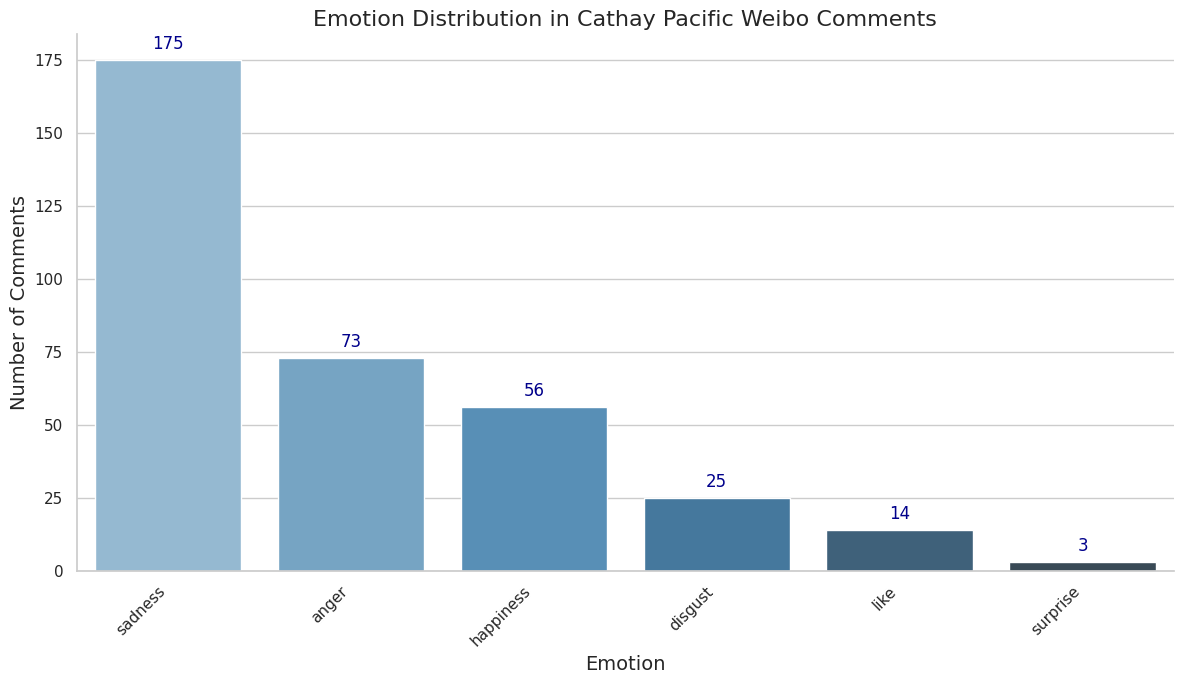

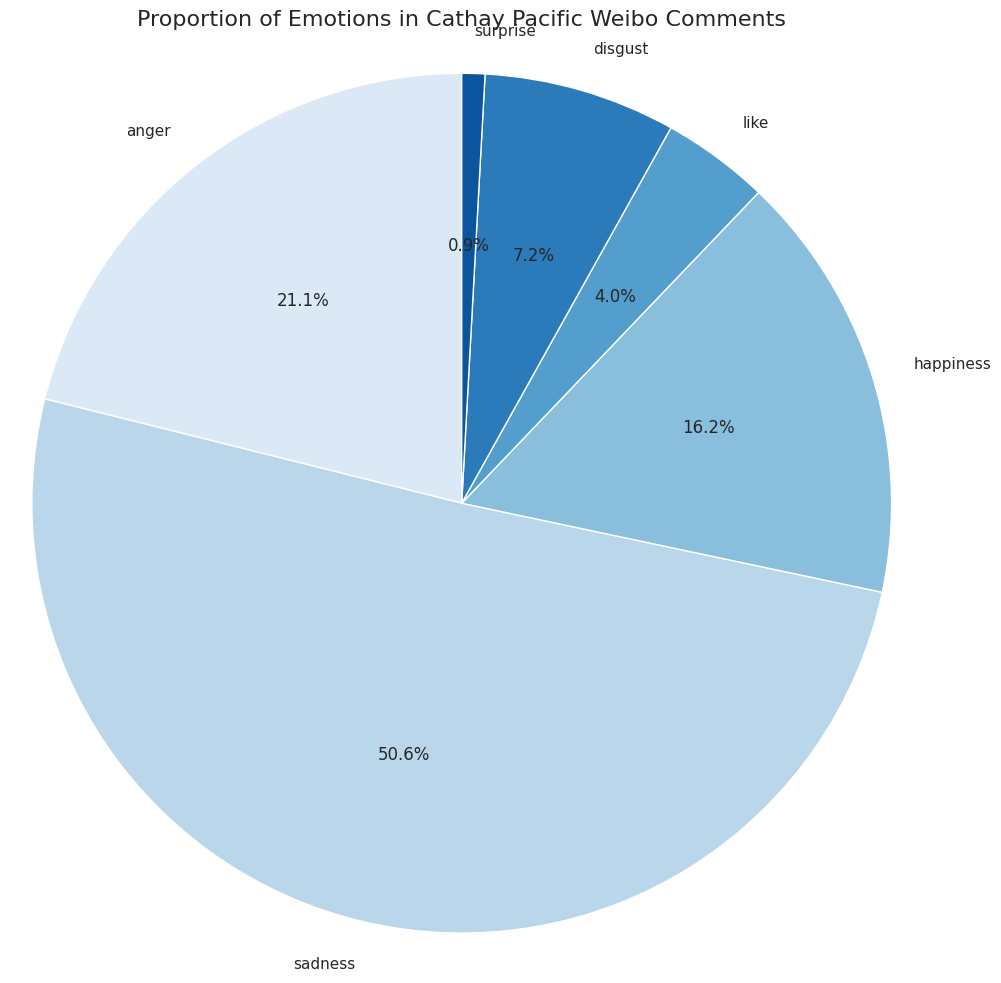

In [26]:
# Count the emotions
emotion_counts = Counter(df['category'])

# Create a DataFrame for plotting
emotion_df = pd.DataFrame({
    'Emotion': emotion_counts.keys(),
    'Count': emotion_counts.values()
}).sort_values('Count', ascending=False)

# Plot the emotion distribution using seaborn for a modern, appealing visualization
plt.figure(figsize=(12, 7))

# Fix deprecated palette parameter by using hue properly
emotion_df['Emotion_Hue'] = emotion_df['Emotion']  # Create hue column with same data as x
ax = sns.barplot(
    x='Emotion',
    y='Count',
    hue='Emotion_Hue',
    data=emotion_df,
    palette="Blues_d",
    legend=False  # No need for a legend since colors already distinguish bars
)

sns.despine()  # Remove top and right spines for cleaner look
ax.set_title('Emotion Distribution in Cathay Pacific Weibo Comments', fontsize=16)
ax.set_xlabel('Emotion', fontsize=14)
ax.set_ylabel('Number of Comments', fontsize=14)

# Fix the UserWarning by getting ticks first and then setting labels
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate labels for better readability

# Add value labels on top of each bar for precise information
for i, p in enumerate(ax.patches):
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=12,
        color='darkblue',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(CHARTS_DIR / "emotion_bar_chart.png")  # Save the figure

# In a notebook this displays the chart without blocking
# In a script, we need to be more careful to avoid hanging
if 'ipykernel' in sys.modules:
    # We're in a notebook environment
    plt.show()
else:
    # We're in a script - don't block
    plt.draw()
    plt.pause(0.001)  # Small pause to render
    plt.close()

# Create a pie chart for percentage distribution
plt.figure(figsize=(10, 10))
plt.pie(
    emotion_counts.values(),
    labels=emotion_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Blues", len(emotion_counts))
)
plt.title('Proportion of Emotions in Cathay Pacific Weibo Comments', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.savefig(CHARTS_DIR / "emotion_pie_chart.png")  # Save the figure

# Handle notebook vs script difference for displaying plots
if 'ipykernel' in sys.modules:
    # We're in a notebook environment
    plt.show()
else:
    # We're in a script - don't block
    plt.draw()
    plt.pause(0.001)  # Small pause to render
    plt.close()

## Emotion Distribution Summary
Below is a summary of the emotion distribution in the dataset.
This provides a quick overview of how customers feel about Cathay Pacific
based on their Weibo comments.

In [27]:
# Print summary statistics in a clear, tabular format
print("\nEmotion Distribution Summary:")
for emotion, count in emotion_counts.most_common():
    percentage = (count / len(df)) * 100
    print(f"{emotion}: {count} comments ({percentage:.1f}%)")


Emotion Distribution Summary:
sadness: 175 comments (50.6%)
anger: 73 comments (21.1%)
happiness: 56 comments (16.2%)
disgust: 25 comments (7.2%)
like: 14 comments (4.0%)
surprise: 3 comments (0.9%)


## Save Results for Further Analysis
We save both the raw results (with emotion labels) and a processed version
that includes confidence scores and formatting for easy review.

In [28]:
# Save the analysis results
try:
    # Save to CSV for data analysis
    output_path = Path("Social_media_analysis/cathay_weibo_emotion_analysis.csv")
    os.makedirs(output_path.parent, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"Analysis results saved to {output_path}")

    # Save processed version with emotions and confidence scores
    processed_path = PROCESSED_INPUTS_DIR / "cathay_weibo_processed.txt"
    with open(processed_path, 'w', encoding='utf-8') as f:
        for i, row in df.iterrows():
            f.write(f"Comment {i+1} [Emotion: {row['category']} (Confidence: {row['confidence']:.3f})]: {row['text']}\n")
    print(f"Processed comments with emotions saved to {processed_path}")
except Exception as e:
    print(f"Error saving analysis results: {str(e)}")
    try:
        # Try an alternative location if the primary save fails
        alt_path = SAVE_DIR / "cathay_weibo_emotion_analysis.csv"
        df.to_csv(alt_path, index=False)
        print(f"Analysis results saved to alternative location: {alt_path}")
    except Exception as e2:
        print(f"Could not save analysis results to any location.")

Analysis results saved to Social_media_analysis/cathay_weibo_emotion_analysis.csv
Processed comments with emotions saved to saved_data/processed_inputs/cathay_weibo_processed.txt


## Sample Comments for Each Emotion to Inspect the Model's Performance
To better understand the model's predictions, we'll examine sample comments for different emotions.
This helps us validate the model's performance and gain insights into how different emotions
are expressed in social media comments about Cathay Pacific.

In [29]:
# Get examples of each emotion for manual inspection
print("Sampling comments from each emotion category...")
emotion_examples = {}

# Get 5 examples of each emotion
for emotion in CATEGORIES:
    emotion_df = df[df['category'] == emotion].head(5)
    if not emotion_df.empty:
        emotion_examples[emotion] = emotion_df['text'].tolist()
    else:
        print(f"No examples found for emotion: {emotion}")

# Display examples for key emotion categories
print("\nExamples from different emotion categories:")

# Group emotions into positive and negative categories
negative_emotions = ["sadness", "anger", "disgust", "fear"]
positive_emotions = ["happiness", "like", "surprise"]

for emotion_type, emotions in [("Positive", positive_emotions), ("Negative", negative_emotions)]:
    print(f"\n{emotion_type} Emotion Examples:")
    for emotion in emotions:
        if emotion in emotion_examples and emotion_examples[emotion]:
            print(f"\n{emotion.upper()}:")
            examples = emotion_examples[emotion]
            for i, example in enumerate(examples[:2], 1):  # Show just 2 examples for brevity
                print(f"{i}. {example}")
        else:
            print(f"No examples found for {emotion}")

Sampling comments from each emotion category...
No examples found for emotion: fear

Examples from different emotion categories:

Positive Emotion Examples:

HAPPINESS:
1. 作为中国香港居民，首先我是一位中国人❤️我乘坐过很多优秀的交通工具，例如中国铁路、中国南方航空、中国东方航空，感受到企业党建和党员先锋岗对促进高质量发展的重大作用，我希望中国香港的先进分子也能入党，带动中国香港各服务行业和全国各地一起高质量发展❤️
2. 这次算是高效处理

LIKE:
1. 特府不错的
2. 也好，不破不立

SURPRISE:
1. 我亲身经历，这次一位空服人员凶我身后的老奶奶，我都惊呆了……我的天啊‼️
2. 我也是很意外居然还有人来个各打五十大板的发言做什么理中客

Negative Emotion Examples:

SADNESS:
1. @国泰航空 希望真的有意识到这个问题的严重性。真的不会要求你都要上升到“爱国”的层面或者所谓立场，但请你们认清自己的工作和这份工作要求的专业性！服务行业是高压行业，但是工作场合如此调笑还被现职人员觉得只是玩笑话，简直可笑！至少人前假笑一下维持下专业。
2. 国泰：痛心，但我就是不改

ANGER:
1. 放氧气，透露乘客信息，嘲笑乘客，这是人干的事吗？还都是国泰航空公司员工干的，既没有职业道德也没有服务意识！
2. 少来吧，世界上哪个优秀的航空公司也没有靠政党引导的，只有更加的私人化市场化才能更好，东航 南航的审美落后世界20年，口号喊得响有什么用？

DISGUST:
1. 换个角度想，当事人乘客无辜，但服务业是吃过多少屎才衍生出来的歧视，跟优越感无关。国民量多，素质低的比例高，有钱了出国也多，导致没素质的事是巨量好吧？歧视/被区别是难以避免的，要抱不平还不如从自己和身边的人开始做好，一点点改变。
2. 有什么用？先把mandy ng换了吧
No examples found for fear


## Model Performance Insights

Obviously, the dataset to analyse only contained negative emotions. But the model wrongly predicted some positive emotions. This is usual for sentiment analysis models.    

Understanding model limitations is crucial for responsible data analysis.
Here are some key insights about the emotion classification model:

- The model may misclassify some comments, especially in cases of subtle sarcasm or complex emotions
- Classification accuracy is affected by the quality and diversity of the training data
- Chinese text analysis presents unique challenges due to language nuances and cultural context
- For production applications, continuous monitoring and model tuning would be necessary

In [30]:
# Clean up resources
print("\nAnalysis complete! Clearing resources...")

# Unload the model from memory to free up resources
if 'model' in locals():
    del model
torch.cuda.empty_cache()
import gc
gc.collect()


Analysis complete! Clearing resources...


10486